<a href="https://colab.research.google.com/github/nishithewel/ID5059GroupProject/blob/anli_1/ID5059_ieee_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initial setup to download dataset from KAggle.

In [1]:
!pip install -q kaggle

Please follow the steps below to download and use kaggle data within Google Colab:

1. Go to your account, Scroll to API section and Click Expire API Token to remove previous tokens

2. Click on Create New API Token - It will download kaggle.json file on your machine

3. Upload the kaggle.json by running below code cell.

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anlihu","key":"c0ef035c4a9e1d5a852ce1fab4c73cb3"}'}

In [3]:
! rm -rf sample_data
!mkdir  -p /root/.kaggle/
!mv kaggle.json  /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
! ls -lart /root/.kaggle/
!kaggle competitions download -c 'ieee-fraud-detection'
! mkdir data
! mv ieee-fraud-detection.zip data/
! unzip data/ieee-fraud-detection.zip -d data/

total 16
-rw------- 1 root root   62 Mar 20 10:50 kaggle.json
drwx------ 1 root root 4096 Mar 20 10:50 ..
drwxr-xr-x 2 root root 4096 Mar 20 10:50 .
 89% 105M/118M [00:00<00:00, 163MB/s] 
100% 118M/118M [00:00<00:00, 159MB/s]
Archive:  data/ieee-fraud-detection.zip
  inflating: data/sample_submission.csv  
  inflating: data/test_identity.csv  
  inflating: data/test_transaction.csv  
  inflating: data/train_identity.csv  
  inflating: data/train_transaction.csv  


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from scipy import stats

In [5]:
train_identity, train_transaction = pd.read_csv('data/train_identity.csv'), pd.read_csv('data/train_transaction.csv')
train_identity.head()

TransactionID  id_01     id_02  id_03  id_04  id_05  id_06  id_07  id_08  \
0        2987004    0.0   70787.0    NaN    NaN    NaN    NaN    NaN    NaN   
1        2987008   -5.0   98945.0    NaN    NaN    0.0   -5.0    NaN    NaN   
2        2987010   -5.0  191631.0    0.0    0.0    0.0    0.0    NaN    NaN   
3        2987011   -5.0  221832.0    NaN    NaN    0.0   -6.0    NaN    NaN   
4        2987016    0.0    7460.0    0.0    0.0    1.0    0.0    NaN    NaN   

   id_09  ...                id_31  id_32      id_33           id_34  id_35  \
0    NaN  ...  samsung browser 6.2   32.0  2220x1080  match_status:2      T   
1    NaN  ...   mobile safari 11.0   32.0   1334x750  match_status:1      T   
2    0.0  ...          chrome 62.0    NaN        NaN             NaN      F   
3    NaN  ...          chrome 62.0    NaN        NaN             NaN      F   
4    0.0  ...          chrome 62.0   24.0   1280x800  match_status:2      T   

  id_36 id_37  id_38  DeviceType                     DeviceInfo  
0     F     T      T      mobile  SAMSUNG SM-G892A Build/NRD90M  
1     F     F      T      mobile                     iOS Device  
2     F     T      T     desktop                        Windows  
3     F     T      T     desktop                            NaN  
4     F     T      T     desktop                          MacOS  

[5 rows x 41 columns]

In [7]:
test_identity, test_transaction = pd.read_csv('data/test_identity.csv'),pd.read_csv('data/test_transaction.csv')
test_transaction.head()

TransactionID  TransactionDT  TransactionAmt ProductCD  card1  card2  \
0        3663549       18403224           31.95         W  10409  111.0   
1        3663550       18403263           49.00         W   4272  111.0   
2        3663551       18403310          171.00         W   4476  574.0   
3        3663552       18403310          284.95         W  10989  360.0   
4        3663553       18403317           67.95         W  18018  452.0   

   card3       card4  card5  card6  ...  V330  V331  V332  V333 V334 V335  \
0  150.0        visa  226.0  debit  ...   NaN   NaN   NaN   NaN  NaN  NaN   
1  150.0        visa  226.0  debit  ...   NaN   NaN   NaN   NaN  NaN  NaN   
2  150.0        visa  226.0  debit  ...   NaN   NaN   NaN   NaN  NaN  NaN   
3  150.0        visa  166.0  debit  ...   NaN   NaN   NaN   NaN  NaN  NaN   
4  150.0  mastercard  117.0  debit  ...   NaN   NaN   NaN   NaN  NaN  NaN   

   V336  V337  V338  V339  
0   NaN   NaN   NaN   NaN  
1   NaN   NaN   NaN   NaN  
2   NaN   NaN   NaN   NaN  
3   NaN   NaN   NaN   NaN  
4   NaN   NaN   NaN   NaN  

[5 rows x 393 columns]

In [8]:
train = pd.merge(train_transaction, train_identity, on = 'TransactionID', how = 'left')
test = pd.merge(test_transaction, test_identity, on = 'TransactionID', how = 'left')

In [9]:
del train_identity, train_transaction, test_identity, test_transaction

In [10]:
new_test_column = [col.replace('-','_') for col in test.columns.values]
test.columns = new_test_column

# Drop Colums

In [11]:
# https://www.kaggle.com/artgor/eda-and-models
one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

In [12]:
many_null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.9]
many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.9]

In [13]:
highly_skew_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
highly_skew_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]

In [14]:
cols_to_drop = list(set(many_null_cols + many_null_cols_test + highly_skew_cols + highly_skew_cols_test + one_value_cols+ one_value_cols_test))
cols_to_drop.remove('isFraud')
len(cols_to_drop)

82

In [15]:
train.drop(cols_to_drop, axis = 1, inplace = True)
test.drop(cols_to_drop, axis = 1, inplace = True)

In [16]:
train_target = train['isFraud']

In [17]:
train = train.drop(['isFraud'], axis = 1)

# Correlation

In [18]:
obj_features = ['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_19', 'id_20', 
            'id_28', 'id_29',
            'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 
            'DeviceType', 'DeviceInfo', 'ProductCD', 
            'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 
            'P_emaildomain', 'R_emaildomain', 
            'addr1', 'addr2', 
            'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']
unique_features = ['TransactionID', 'TransactionDT'] 
num_features = list(set(train.columns).difference(set(obj_features + unique_features)))


In [19]:
len(num_features)

308

## Categorical Features

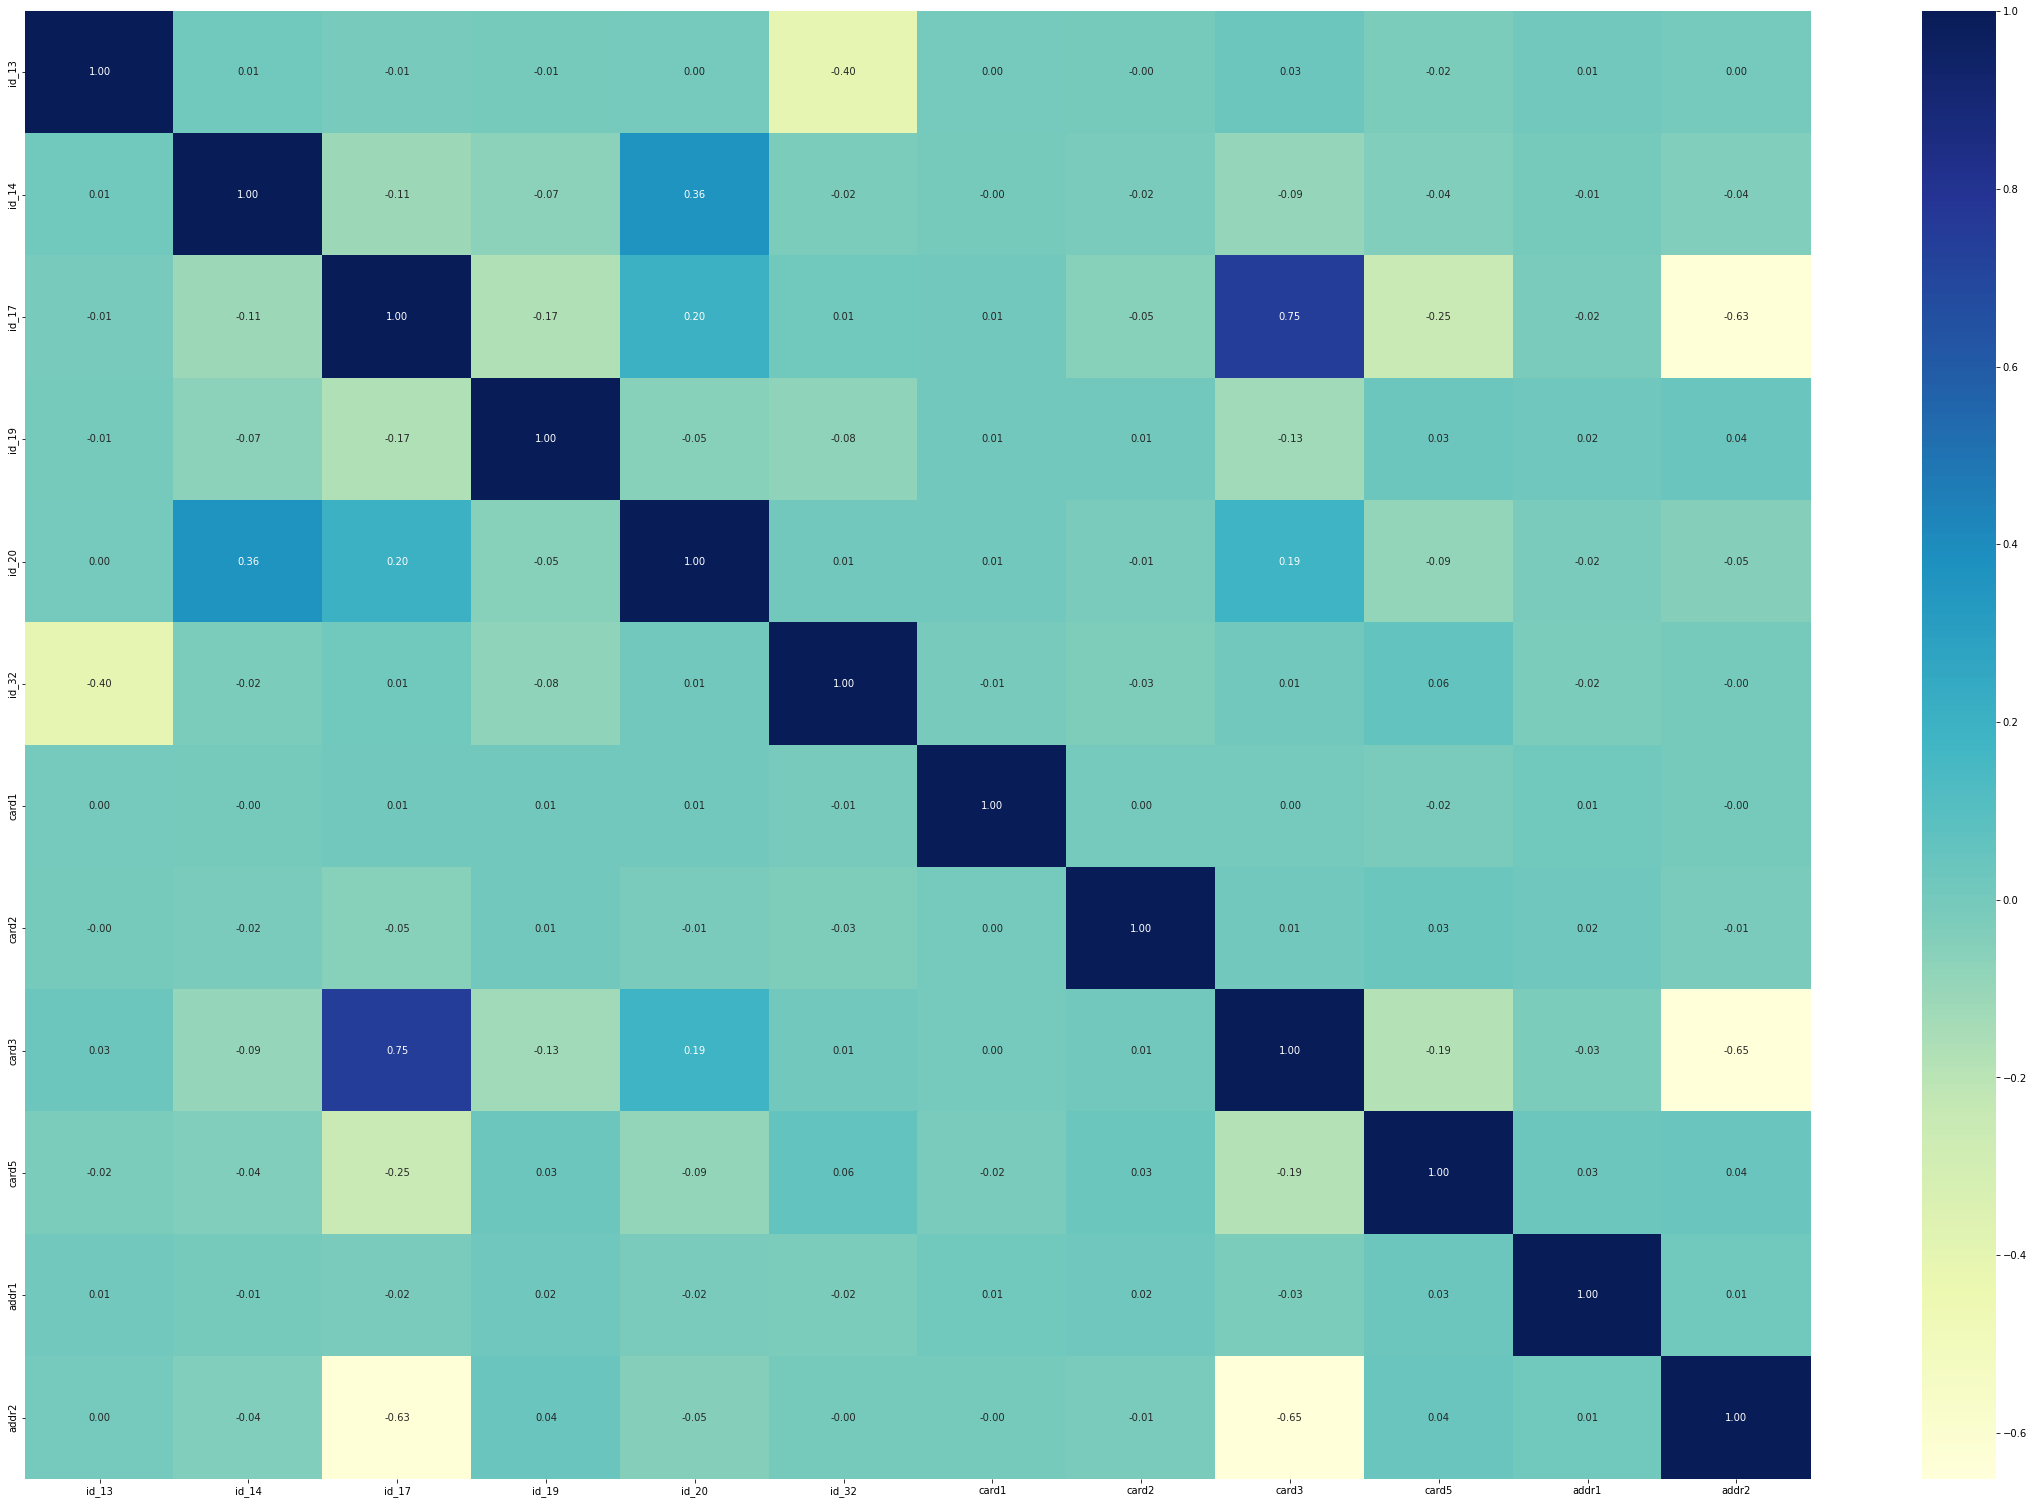

In [20]:
plt.figure(figsize=(40,27))
sns.heatmap(train[obj_features].corr(method = 'kendall'), annot = True, fmt = ".2f", cmap = "YlGnBu")
plt.show()

## Numerical Features

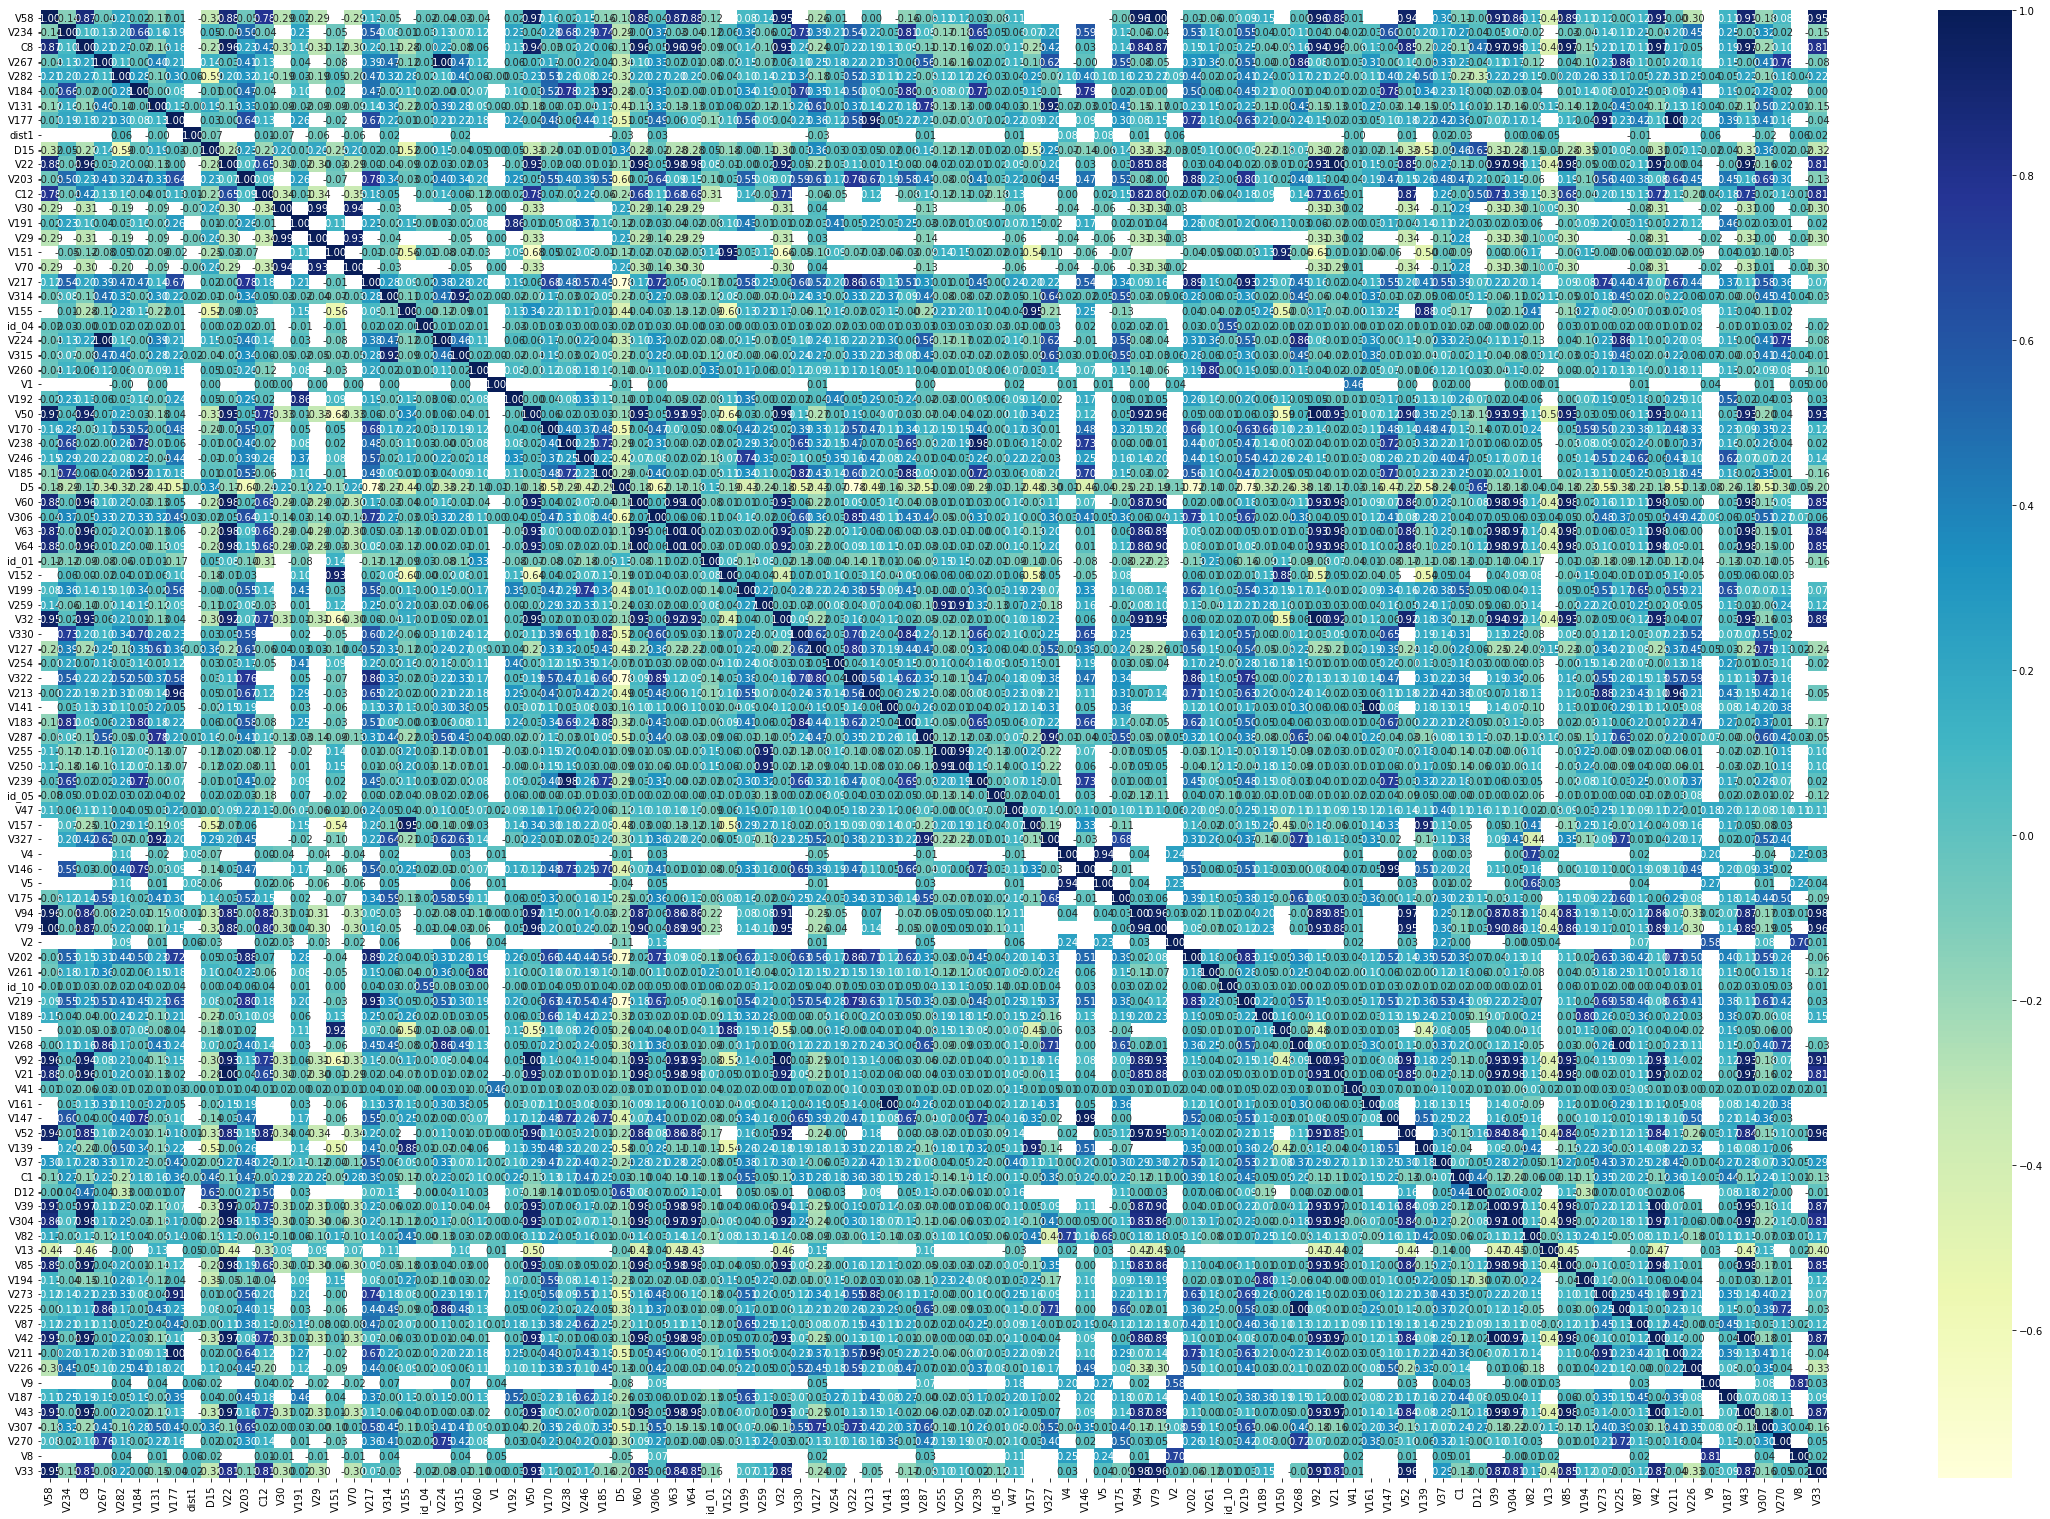

In [21]:
featrue_part_1 = num_features[0:100]
plt.figure(figsize = (40,27))
sns.heatmap(train[featrue_part_1].corr(method = 'spearman'), annot = True, fmt = ".2f", cmap = "YlGnBu")
plt.show()

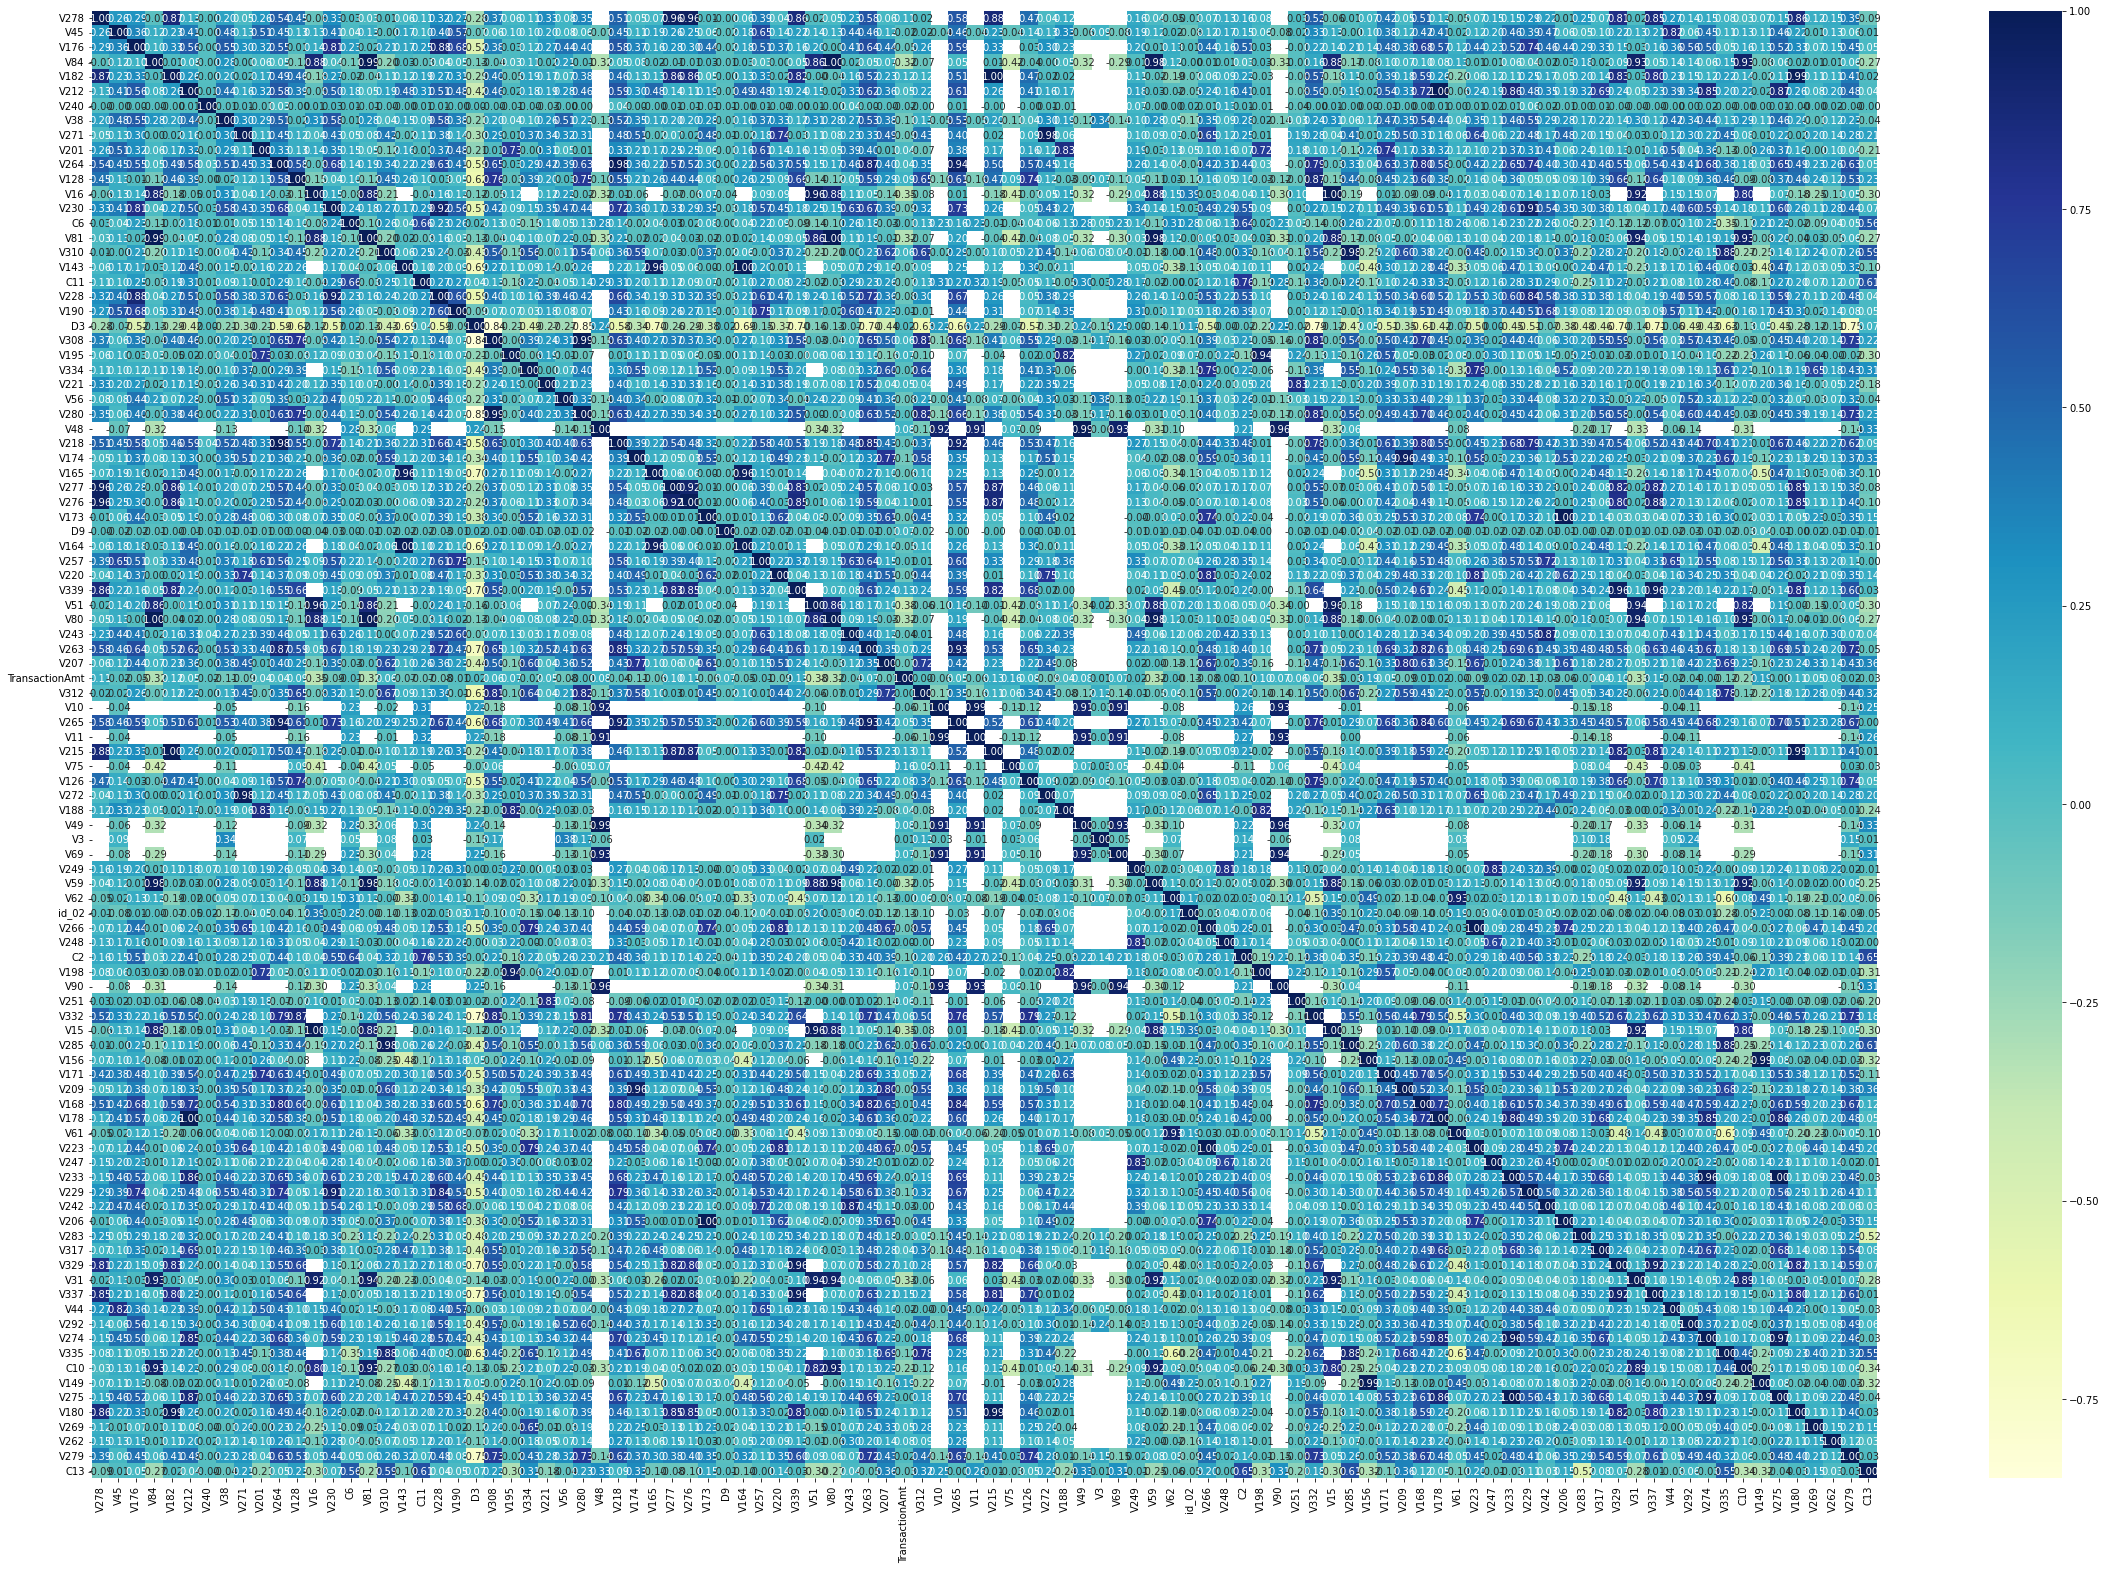

In [22]:
featrue_part_2 = num_features[100:200]
plt.figure(figsize = (40,27))
sns.heatmap(train[featrue_part_2].corr(method = 'spearman'), annot = True, fmt = ".2f", cmap = "YlGnBu")
plt.show()

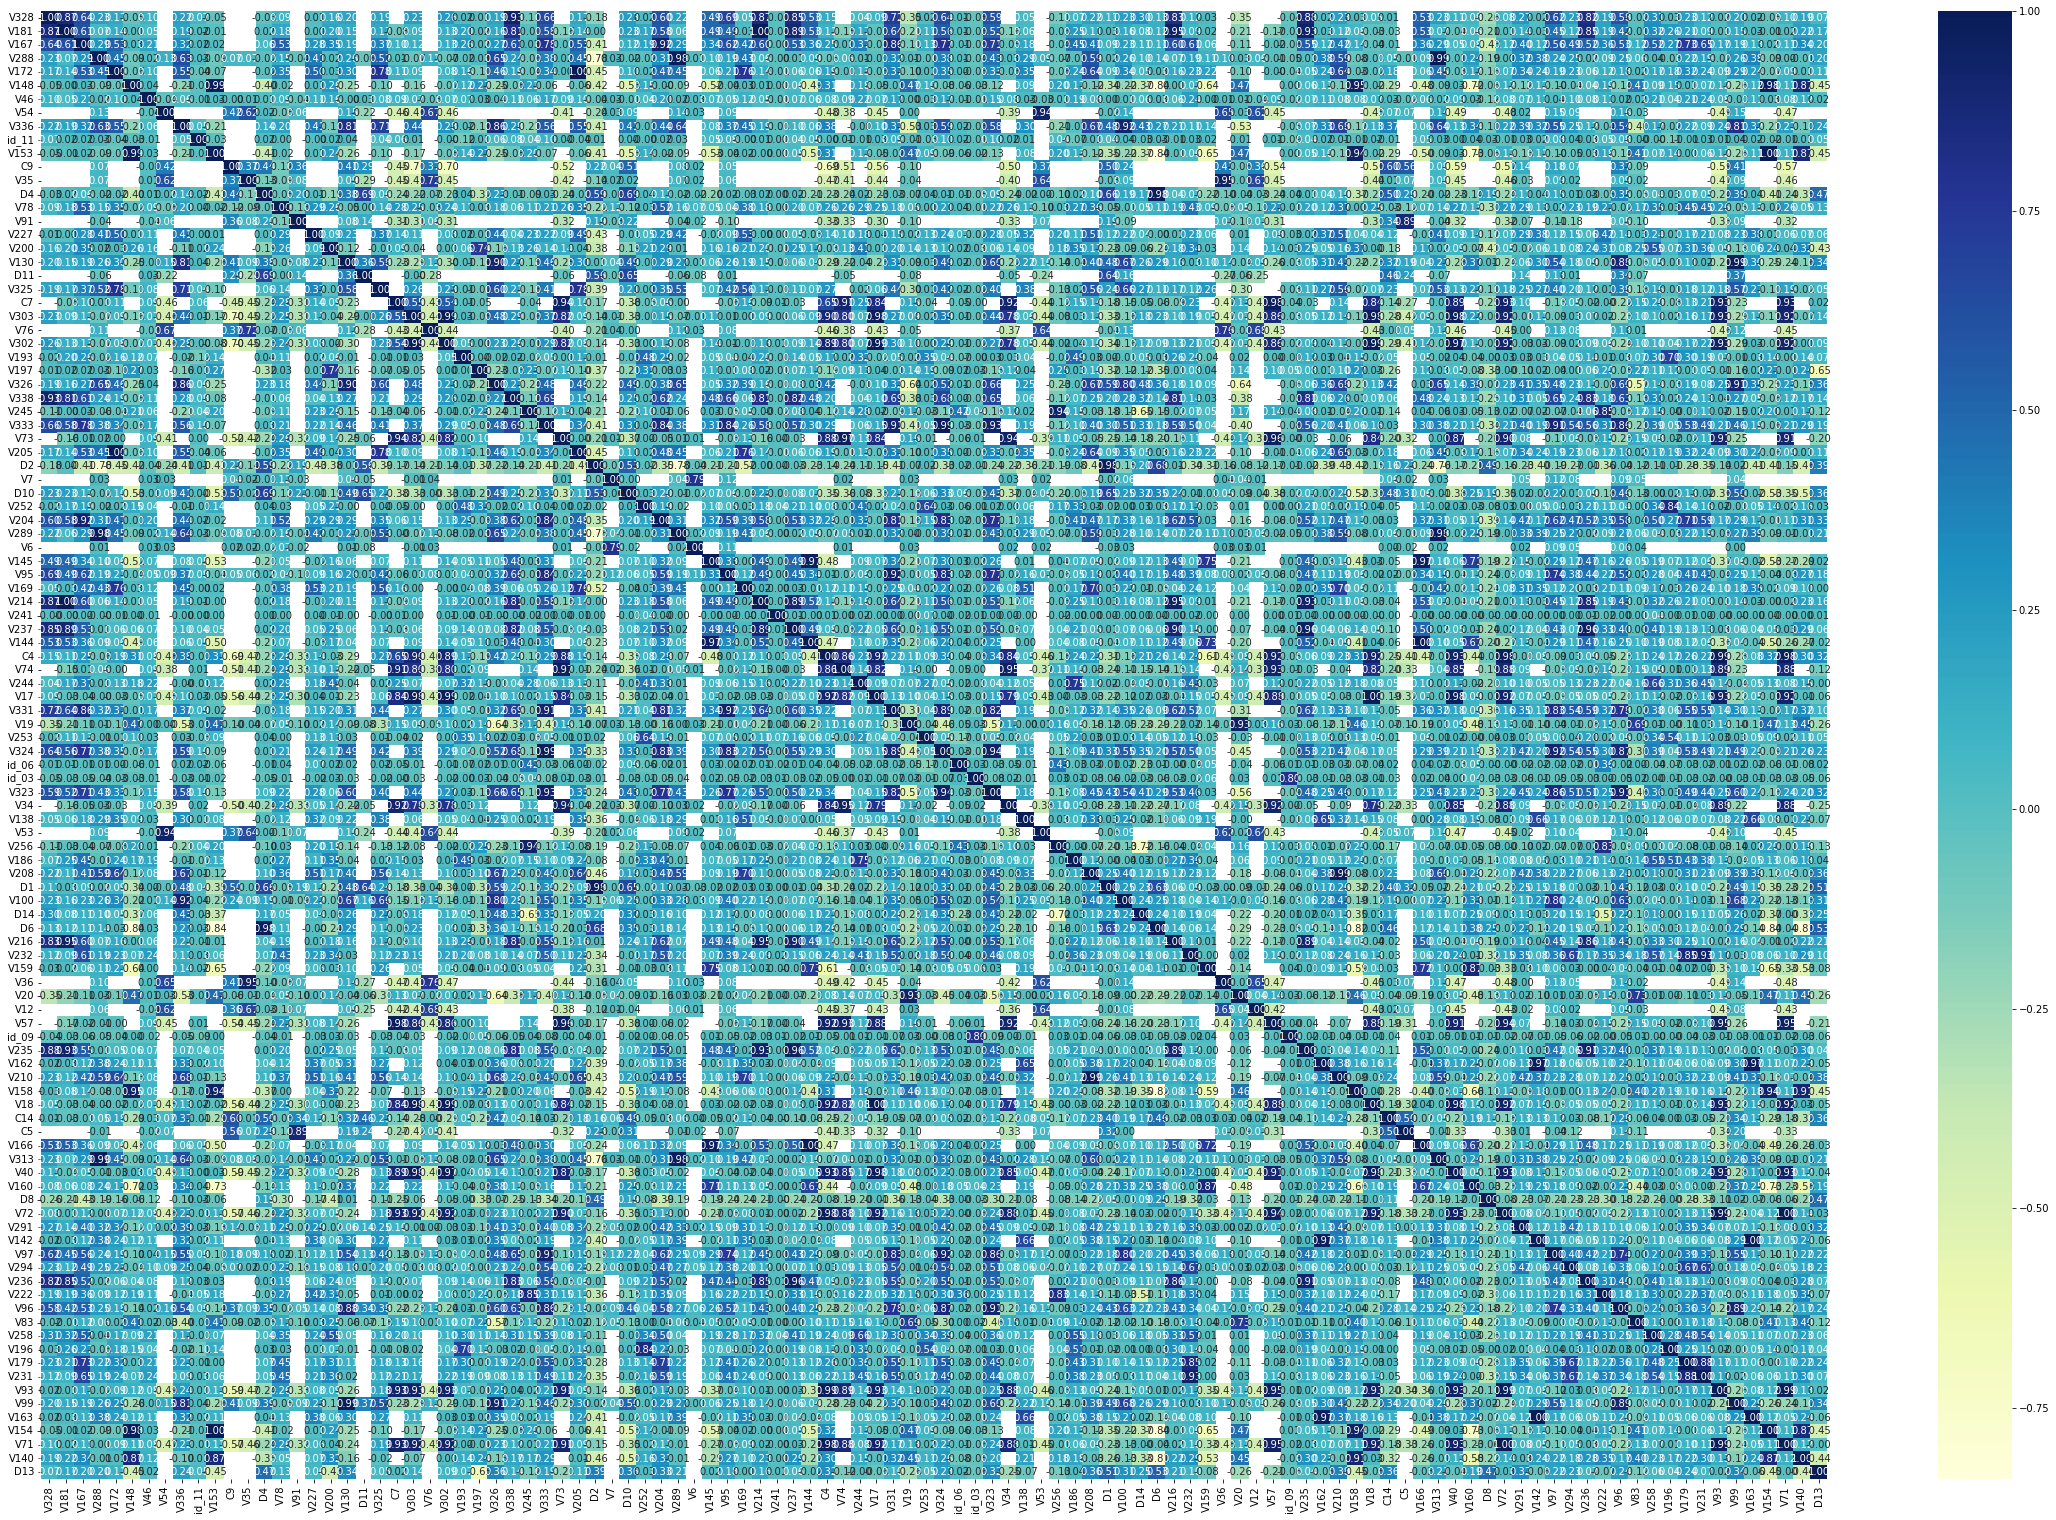

In [23]:
featrue_part_3 = num_features[200:]
plt.figure(figsize = (40,27))
sns.heatmap(train[featrue_part_3].corr(method = 'spearman'), annot = True, fmt = ".2f", cmap = "YlGnBu")
plt.show()

# Column Imputation

In [3]:
all_features = pd.concat((train,test))

NameError: ignored

In [ ]:
all_features.drop(['TransactionID', 'TransactionDT'], axis = 1,inplace = True)

In [ ]:
# by https://www.kaggle.com/dimartinot
def clean_inf_nan(df):
    return df.replace([np.inf, -np.inf], np.nan)   

# Cleaning infinite values to NaN
all_features = clean_inf_nan(all_features)

In [ ]:
lb = LabelEncoder()
for i in obj_features:  
    all_features[i] = lb.fit_transform(all_features[i].astype(str))

In [ ]:
# Normalization
all_features[num_features] = all_features[num_features].apply(
    lambda x: (x-x.mean())/ x.std())
all_features[num_features] = all_features[num_features].fillna(0)

In [ ]:
all_features = all_features.astype(np.float64)

In [ ]:
train_clean = all_features.iloc[:train.shape[0],:]
test_clean = all_features.iloc[train.shape[0]:,:]